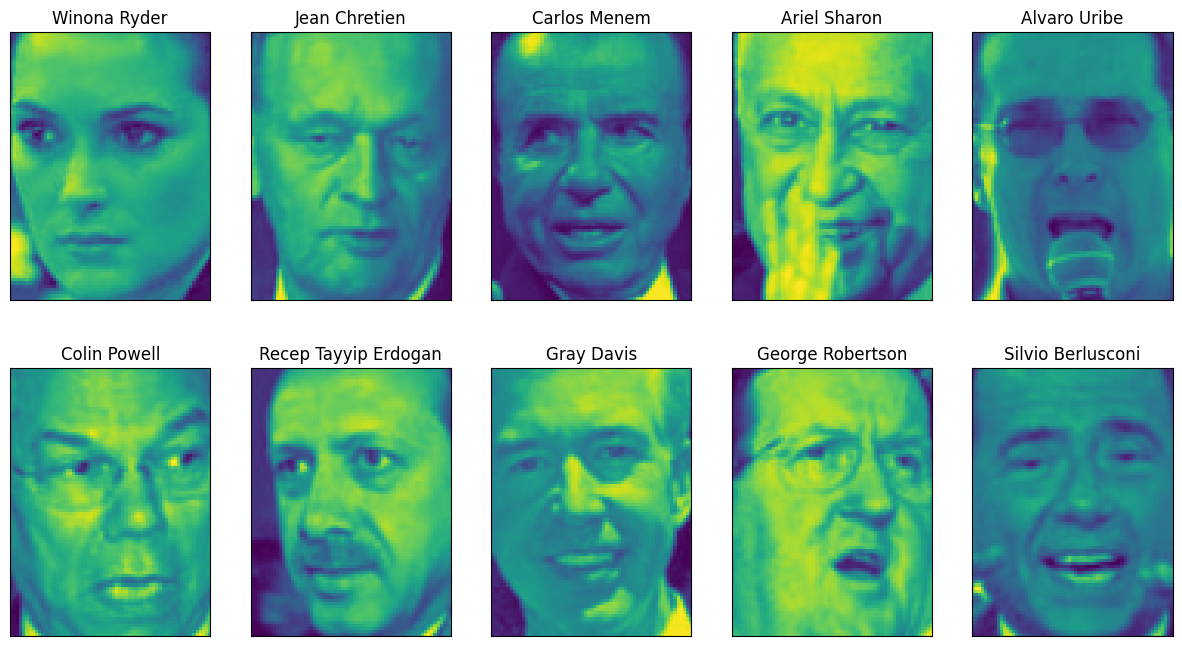

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# On peut utiliser l'analyse en composante principale pour extraire des caractéristiques d'un jeu de données

# Eigenfaces : ensemble de vecteurs propres utilisés dans le domaine de la vision artificielle https://fr.wikipedia.org/wiki/Eigenface

# Des images peuvent être téléchargé depuis ce site https://vis-www.cs.umass.edu/lfw/

from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

fig,axes = plt.subplots(2,5, figsize=(15,8), subplot_kw={'xticks':(),'yticks':()})
for target,image,ax in zip(people.target,people.images,axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [7]:
print("Format des données : {}".format(people.images.shape))
print("Classes : {}".format(people.target_names))

Format des données : (3023, 87, 65)
Classes : ['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Saddam Hussein'
 'Serena Willia

In [10]:
# Certaines personnalités sont représentées plus que d'autres :
import numpy as np

counts = np.bincount(people.target)
for i, (count,name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name,count), end='    ')
    if ( i + 1) % 3 == 0:
        print()

Alejandro Toledo           39    Alvaro Uribe               35    Amelie Mauresmo            21    
Andre Agassi               36    Angelina Jolie             20    Ariel Sharon               77    
Arnold Schwarzenegger      42    Atal Bihari Vajpayee       24    Bill Clinton               29    
Carlos Menem               21    Colin Powell              236    David Beckham              31    
Donald Rumsfeld           121    George Robertson           22    George W Bush             530    
Gerhard Schroeder         109    Gloria Macapagal Arroyo    44    Gray Davis                 26    
Guillermo Coria            30    Hamid Karzai               22    Hans Blix                  39    
Hugo Chavez                71    Igor Ivanov                20    Jack Straw                 28    
Jacques Chirac             52    Jean Chretien              55    Jennifer Aniston           21    
Jennifer Capriati          42    Jennifer Lopez             21    Jeremy Greenstock          24    


In [42]:
# Afin de ne pas faire dévier ( pré-éminence de certaines personnalités ) l'extraction de caractéristiques,
# on limite à 50 images

mask = np.zeros(people.target.shape, dtype=np.bool_)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1 

X_people = people.data[mask]
y_people = people.target[mask]


In [37]:
# On souhaiterait pouvoir ajouter des personnes à la classification sans pour autant avoir à ré-entraînner 
# tout le modèle à chaque nouvel ajout. Par ailleurs, la nouvelle classe pourrait avoir un nombre d'échantillon
# plus petit.
# Le plus simple serait de vérifier si la personne n'est pas déjà connue (classifiable de prime abord) en utilisant
# un classifieur "un plus proche voisin"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_people,y_people,stratify=y_people,random_state=0)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
print("Score de test pour le classifieur 1-voisin {:.3f}".format(knn.score(X_test,y_test)))

Score de test pour le classifieur 1-voisin 0.215


In [38]:
# Soit 1 personne sur 5 identifiable. 
# La manière de mesurer les similitudes entre les visages en calculant la distance entre les pixels semble être une
# méthode inefficace. Le calcul de distance entre pixel correspond à un calcul de différence de niveau de gris.

# En utilisant PCA plutôt que les images originelles comme donées pour l'entraînement du modèle de classification

from sklearn.decomposition import PCA

# On utilise StandardScaler directement dans pca avec l'option whiten = True
pca = PCA(n_components=100,whiten=True,random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Forme pca : {}".format(X_train_pca.shape))

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca,y_train)
print("Précision pour le test sur les données transformées par PCA : {}".format(knn.score(X_test_pca,y_test)))

Forme pca : (1547, 100)
Précision pour le test sur les données transformées par PCA : 0.29651162790697677


pca.components_.shape: (100, 5655)



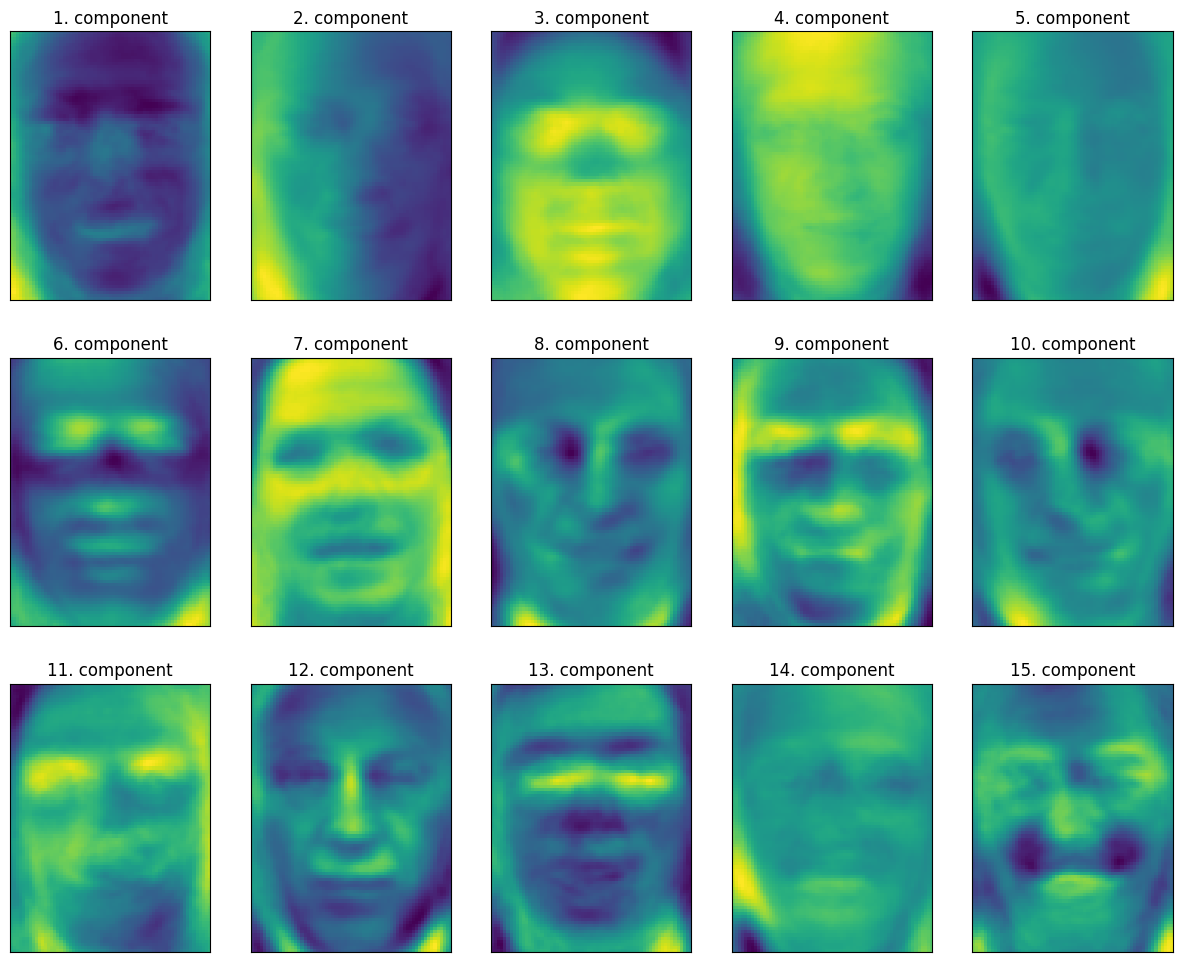

In [39]:
# On améliore la précision de 9%, soit 1 personne sur 3 identifiable
# La représentation des données sous la forme de composantes principales semble être une meilleure représentation
# quant à leur classification avec knn-1

# Visualisation des 15 premières composantes principales
print("pca.components_.shape: {}".format(pca.components_.shape))
print()
fig, axes = plt.subplots(3,5, figsize=(15,12), subplot_kw={'xticks':(),'yticks':()})
image_shape = people.images[0].shape
for i, (component,ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),cmap='viridis')
    ax.set_title("{}. component".format((i+1)))

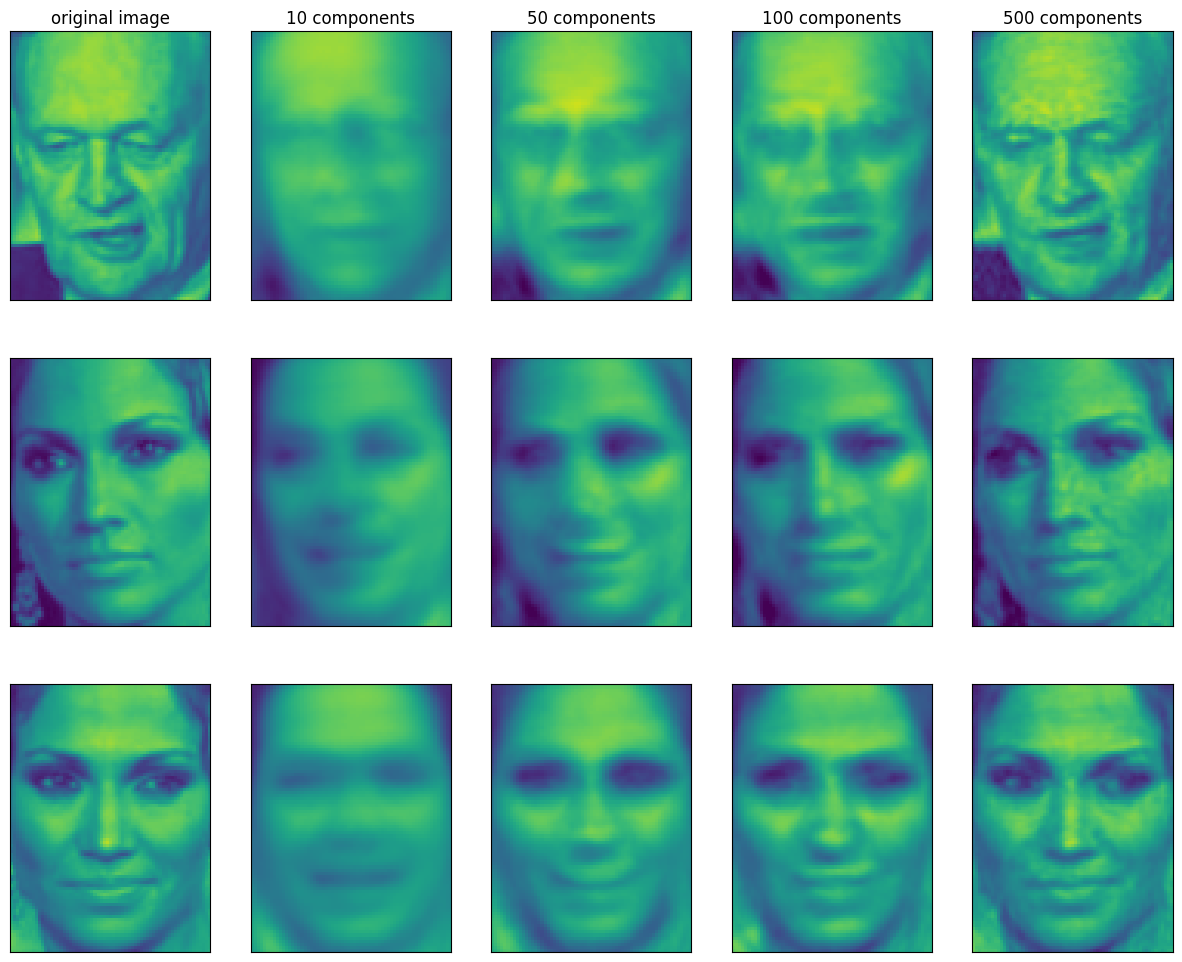

In [41]:
# En reconstruisant les images originales grâce aux composantes principales avec 10,50,100 et 500 composantes



mglearn.plots.plot_pca_faces(X_train,X_test,image_shape)